## LUAD cell type fractions

In [1]:
import pertpy as pt

/home/kvalem/.conda/envs/pertpy-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/kvalem/.conda/envs/pertpy-env/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/kvalem/.conda/envs/pertpy-env/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/kvalem/.conda/envs/pertpy-env/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/home/kvalem/.conda/envs/pertpy-env/lib/python3.10/site-p

In [2]:
import scanpy as sc

In [3]:
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import mudata as mu

In [4]:
import sccoda.util.cell_composition_data as scc_dat
import sccoda.util.comp_ana as scc_ana
import sccoda.util.data_visualization as scc_viz

2024-12-04 10:31:42.504771: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733304702.523688 2651040 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733304702.529599 2651040 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
path = "/data/projects/2023/LCBiome/nsclc_gender_atlas_tmp/out/011_analysis_paired_remove_xy/pseudobulk/"
resDir = "/data/projects/2023/LCBiome/nsclc_gender_atlas_tmp/out/011_analysis_paired_remove_xy/figures/"
input_path = f"{path}/paired_adata_clean.h5ad"

In [6]:
adata = sc.read_h5ad(input_path)

In [7]:
adata.obs["cell_type_major"].replace("Macrophage alveolar", "Macrophage", inplace=True)

In [8]:
adata = adata[
    ~adata.obs["cell_type_major"].isin(["transitional club/AT2", "Ciliated", "other"])
]

In [9]:
adata.obs.cell_type_major.value_counts()

cell_type_major
Macrophage           130447
T cell CD4           118739
T cell CD8            96754
B cell                27723
Tumor cells           25793
T cell regulatory     23411
Neutrophils           15244
DC mature              1158
Name: count, dtype: int64

In [10]:
adata.obs.disease.value_counts()

disease
lung adenocarcinoma              325886
squamous cell lung carcinoma      93286
non-small cell lung carcinoma     20097
Name: count, dtype: int64

In [11]:
adata

View of AnnData object with n_obs × n_vars = 439269 × 17811
    obs: 'sample', 'uicc_stage', 'ever_smoker', 'age', 'donor_id', 'origin', 'dataset', 'ann_fine', 'cell_type_predicted', 'doublet_status', 'leiden', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'ann_coarse', 'cell_type_tumor', 'tumor_stage', 'EGFR_mutation', 'TP53_mutation', 'ALK_mutation', 'BRAF_mutation', 'ERBB2_mutation', 'KRAS_mutation', 'ROS_mutation', 'origin_fine', 'study', 'platform', 'cell_type_major', 'cell_type_neutro', 'cell_type_neutro_coarse', 'suspension_type', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage'
    var: 'is_highly_variable', 'mito', 'n_cells_by_

In [12]:
adata = adata[adata.obs["disease"]=="lung adenocarcinoma"]

In [13]:
adata

View of AnnData object with n_obs × n_vars = 325886 × 17811
    obs: 'sample', 'uicc_stage', 'ever_smoker', 'age', 'donor_id', 'origin', 'dataset', 'ann_fine', 'cell_type_predicted', 'doublet_status', 'leiden', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'ann_coarse', 'cell_type_tumor', 'tumor_stage', 'EGFR_mutation', 'TP53_mutation', 'ALK_mutation', 'BRAF_mutation', 'ERBB2_mutation', 'KRAS_mutation', 'ROS_mutation', 'origin_fine', 'study', 'platform', 'cell_type_major', 'cell_type_neutro', 'cell_type_neutro_coarse', 'suspension_type', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage'
    var: 'is_highly_variable', 'mito', 'n_cells_by_

In [17]:
sccoda_model = pt.tl.Sccoda()
sccoda_data = sccoda_model.load(
    adata,
    type="cell_level",
    generate_sample_level=True,
    cell_type_identifier="cell_type_major",
    sample_identifier="donor_id",
    covariate_obs=["disease","dataset","sex"],
)
print(sccoda_data)
print(sccoda_data["coda"].X)
print(sccoda_data["coda"].obs)

! Covariate dataset has non-unique values for batch! Skipping...
MuData object with n_obs × n_vars = 325951 × 17819
  2 modalities
    rna:	325886 x 17811
      obs:	'sample', 'uicc_stage', 'ever_smoker', 'age', 'donor_id', 'origin', 'dataset', 'ann_fine', 'cell_type_predicted', 'doublet_status', 'leiden', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'ann_coarse', 'cell_type_tumor', 'tumor_stage', 'EGFR_mutation', 'TP53_mutation', 'ALK_mutation', 'BRAF_mutation', 'ERBB2_mutation', 'KRAS_mutation', 'ROS_mutation', 'origin_fine', 'study', 'platform', 'cell_type_major', 'cell_type_neutro', 'cell_type_neutro_coarse', 'suspension_type', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', '

In [18]:
# Select control and salmonella data
sccoda_data.mod["coda_sex"] = sccoda_data["coda"][
    sccoda_data["coda"].obs["sex"].isin(["male", "female"])
].copy()
print(sccoda_data["coda_sex"])

AnnData object with n_obs × n_vars = 65 × 8
    obs: 'disease', 'donor_id', 'sex'
    var: 'n_cells'


In [22]:
sccoda_data = sccoda_model.prepare(
    sccoda_data,
    modality_key="coda_sex",
    formula="sex",
    reference_cell_type="automatic",
)
sccoda_data["coda_sex"]

• Automatic reference selection! Reference cell type set to T cell regulatory
• Zero counts encountered in data! Added a pseudocount of 0.5.


AnnData object with n_obs × n_vars = 65 × 8
    obs: 'disease', 'donor_id', 'sex'
    var: 'n_cells'
    uns: 'scCODA_params'
    obsm: 'covariate_matrix', 'sample_counts'

In [24]:
sccoda_data["coda_sex"]

AnnData object with n_obs × n_vars = 65 × 8
    obs: 'disease', 'donor_id', 'sex'
    var: 'n_cells'
    uns: 'scCODA_params'
    obsm: 'covariate_matrix', 'sample_counts'

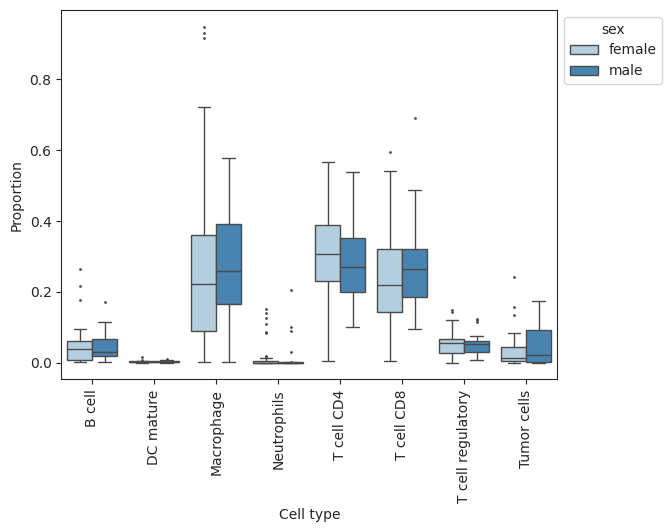

In [28]:
sccoda_model.plot_boxplots(sccoda_data, modality_key="coda_sex", feature_name="sex", add_dots=False)
plt.show()

In [29]:
# Run MCMC
sccoda_model.run_nuts(sccoda_data, modality_key="coda_sex")
sccoda_data["coda_sex"]

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
sample: 100%|██████████| 11000/11000 [01:30<00:00, 121.62it/s, 63 steps of size 5.97e-02. acc. prob=0.74]


AnnData object with n_obs × n_vars = 65 × 8
    obs: 'disease', 'donor_id', 'sex'
    var: 'n_cells'
    uns: 'scCODA_params'
    obsm: 'covariate_matrix', 'sample_counts'
    varm: 'intercept_df', 'effect_df_sex[T.male]'

In [30]:
sccoda_model.summary(sccoda_data, modality_key="coda_sex")

                                          Compositional Analysis summary                                           
┌─────────────────────────────────────────────┬───────────────────────────────────────────────────────────────────┐
│ Name                                        │ Value                                                             │
├─────────────────────────────────────────────┼───────────────────────────────────────────────────────────────────┤
│ Data                                        │ Data: 65 samples, 8 cell types                                    │
│ Reference cell type                         │ T cell regulatory                                                 │
│ Formula                                     │ sex                                                               │
└─────────────────────────────────────────────┴───────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Intercepts                                                                                                      │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                    Final Parameter  Expected Sample                                                             │
│ Cell Type                                                                                                       │
│ B cell                 -0.615           352.237                                                                 │
│ DC mature              -1.428           156.226                                                                 │
│ Macrophage              0.363           936.645                                                                 │
│ Neutrophils            -1.706           118.309                                                                 │
│ T cell CD4              0.827          1489.661                                                                 │
│ T cell CD8              0.651          1249.257                                                                 │
│ T cell regulatory      -0.379           445.993                                                                 │
│ Tumor cells            -0.896           265.949                                                                 │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects                                                                                                         │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                              Final Parameter  Expected Sample  log2-fold change                                 │
│ Covariate Cell Type                                                                                             │
│ sexT.male B cell                 0.000            352.237           0.000                                       │
│           DC mature              0.000            156.226           0.000                                       │
│           Macrophage             0.000            936.645           0.000                                       │
│           Neutrophils            0.000            118.309           0.000                                       │
│           T cell CD4             0.000           1489.661           0.000                                       │
│           T cell CD8             0.000           1249.257           0.000                                       │
│           T cell regulatory      0.000            445.993           0.000                                       │
│           Tumor cells            0.000            265.949           0.000                                       │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

In [31]:
sccoda_model.credible_effects(sccoda_data, modality_key="coda_sex")

Covariate    Cell Type        
sex[T.male]  B cell               False
             DC mature            False
             Macrophage           False
             Neutrophils          False
             T cell CD4           False
             T cell CD8           False
             T cell regulatory    False
             Tumor cells          False
Name: Final Parameter, dtype: bool

In [33]:
#sccoda_model.plot_effects_barplot(sccoda_data, modality_key="coda_sex", parameter="Final Parameter")

In [34]:
sccoda_model.set_fdr(sccoda_data, modality_key="coda_sex", est_fdr=0.4)
sccoda_model.summary(sccoda_data, modality_key="coda_sex")

                                          Compositional Analysis summary                                           
┌─────────────────────────────────────────────┬───────────────────────────────────────────────────────────────────┐
│ Name                                        │ Value                                                             │
├─────────────────────────────────────────────┼───────────────────────────────────────────────────────────────────┤
│ Data                                        │ Data: 65 samples, 8 cell types                                    │
│ Reference cell type                         │ T cell regulatory                                                 │
│ Formula                                     │ sex                                                               │
└─────────────────────────────────────────────┴───────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Intercepts                                                                                                      │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                    Final Parameter  Expected Sample                                                             │
│ Cell Type                                                                                                       │
│ B cell                 -0.615           352.237                                                                 │
│ DC mature              -1.428           156.226                                                                 │
│ Macrophage              0.363           936.645                                                                 │
│ Neutrophils            -1.706           118.309                                                                 │
│ T cell CD4              0.827          1489.661                                                                 │
│ T cell CD8              0.651          1249.257                                                                 │
│ T cell regulatory      -0.379           445.993                                                                 │
│ Tumor cells            -0.896           265.949                                                                 │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects                                                                                                         │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                              Final Parameter  Expected Sample  log2-fold change                                 │
│ Covariate Cell Type                                                                                             │
│ sexT.male B cell                 0.000            333.323           -0.080                                      │
│           DC mature              0.000            147.837           -0.080                                      │
│           Macrophage             0.000            886.350           -0.080                                      │
│           Neutrophils            0.000            111.957           -0.080                                      │
│           T cell CD4             0.000           1409.671           -0.080                                      │
│           T cell CD8             0.205           1451.426            0.216                                      │
│           T cell regulatory      0.000            422.045           -0.080                                      │
│           Tumor cells            0.000            251.668           -0.080                                      │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

In [40]:
sccoda_data

MuData object with n_obs × n_vars = 325951 × 17819
  3 modalities
    rna:	325886 x 17811
      obs:	'sample', 'uicc_stage', 'ever_smoker', 'age', 'donor_id', 'origin', 'dataset', 'ann_fine', 'cell_type_predicted', 'doublet_status', 'leiden', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'ann_coarse', 'cell_type_tumor', 'tumor_stage', 'EGFR_mutation', 'TP53_mutation', 'ALK_mutation', 'BRAF_mutation', 'ERBB2_mutation', 'KRAS_mutation', 'ROS_mutation', 'origin_fine', 'study', 'platform', 'cell_type_major', 'cell_type_neutro', 'cell_type_neutro_coarse', 'suspension_type', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'scCODA_sample_id'
      var:	'is_highly_variable', 'mito', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype'
      uns:	'_scvi', 'ann_fine_colors', 'batch_condition', 'cell_type_tumor_colors', 'dataset_colors', 'default_embedding', 'hvg', 'log1p', 'neighbors', 'origin_colors', 'platform_colors', 'schema_version', 'sex_colors', 'title', 'umap'
      obsm:	'X_scANVI', 'X_scVI', 'X_umap'
      layers:	'count', 'counts_length_scaled', 'log1p_norm'
      obsp:	'connectivities', 'distances'
    coda:	65 x 8
      obs:	'disease', 'donor_id', 'sex'
      var:	'n_cells'
    coda_sex:	65 x 8
      obs:	'disease', 'donor_id', 'sex'
      var:	'n_cells'
      uns:	'scCODA_params'
      obsm:	'covariate_matrix', 'sample_counts'
      varm:	'intercept_df', 'effect_df_sex[T.male]'

In [41]:
#path = "./sccoda_model/sccoda_model"
#sccoda_data.write_h5mu(path)

#sccoda_data_2 = mu.read_h5mu(path)

#sccoda_model.summary(sccoda_data_2, modality_key="coda_sex")

In [42]:
test_model = pt.tl.Sccoda()

In [44]:
test_model.get_intercept_df(sccoda_data, modality_key="coda_sex")

,Final Parameter,HDI 3%,HDI 97%,SD,Expected Sample
Cell Type,,,,,
B cell,-0.615,-0.860,-0.369,0.131,352.236893
DC mature,-1.428,-1.690,-1.189,0.133,156.226041
Macrophage,0.363,0.116,0.584,0.126,936.644625
Neutrophils,-1.706,-1.960,-1.446,0.137,118.309485
T cell CD4,0.827,0.615,1.034,0.113,1489.661127
T cell CD8,0.651,0.406,0.872,0.126,1249.256610
T cell regulatory,-0.379,-0.600,-0.165,0.116,445.993305
Tumor cells,-0.896,-1.140,-0.642,0.132,265.948835


In [45]:
test_model.get_effect_df(sccoda_data, modality_key="coda_sex")

Final Parameter  HDI 3%  HDI 97%     SD  \
Covariate Cell Type                                                    
sexT.male B cell                     0.00000  -0.237    0.352  0.105   
          DC mature                  0.00000  -0.238    0.338  0.097   
          Macrophage                 0.00000  -0.173    0.427  0.124   
          Neutrophils                0.00000  -0.371    0.221  0.107   
          T cell CD4                 0.00000  -0.125    0.417  0.120   
          T cell CD8                 0.20519  -0.067    0.543  0.179   
          T cell regulatory          0.00000   0.000    0.000  0.000   
          Tumor cells                0.00000  -0.202    0.390  0.109   

                             Inclusion probability  Expected Sample  \
Covariate Cell Type                                                   
sexT.male B cell                            0.4553       333.322906   
          DC mature                         0.4416       147.837206   
          Macrophage                        0.4749       886.349824   
          Neutrophils                       0.4562       111.956646   
          T cell CD4                        0.4928      1409.671121   
          T cell CD8                        0.6816      1451.426080   
          T cell regulatory                 0.0000       422.044901   
          Tumor cells                       0.4474       251.668239   

                             log2-fold change  
Covariate Cell Type                            
sexT.male B cell                    -0.079626  
          DC mature                 -0.079626  
          Macrophage                -0.079626  
          Neutrophils               -0.079626  
          T cell CD4                -0.079626  
          T cell CD8                 0.216401  
          T cell regulatory         -0.079626  
          Tumor cells               -0.079626

In [46]:
sccoda_data["coda_sex"].varm["intercept_df"]

,Final Parameter,HDI 3%,HDI 97%,SD,Expected Sample
Cell Type,,,,,
B cell,-0.615,-0.860,-0.369,0.131,352.236893
DC mature,-1.428,-1.690,-1.189,0.133,156.226041
Macrophage,0.363,0.116,0.584,0.126,936.644625
Neutrophils,-1.706,-1.960,-1.446,0.137,118.309485
T cell CD4,0.827,0.615,1.034,0.113,1489.661127
T cell CD8,0.651,0.406,0.872,0.126,1249.256610
T cell regulatory,-0.379,-0.600,-0.165,0.116,445.993305
Tumor cells,-0.896,-1.140,-0.642,0.132,265.948835


In [47]:
import warnings

warnings.filterwarnings("ignore")

import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
import pertpy as pt

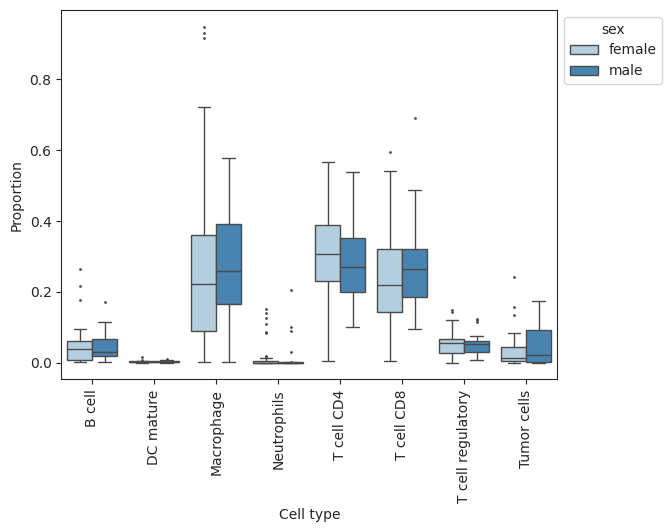

In [53]:
sccoda_model.plot_boxplots(sccoda_data, modality_key="coda_sex", feature_name="sex", add_dots=False)
plt.show()

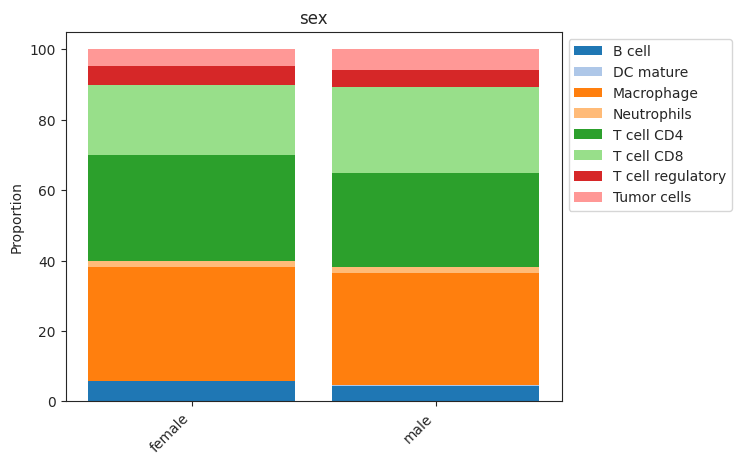

In [62]:
sccoda_model.plot_stacked_barplot(sccoda_data, modality_key="coda_sex", feature_name="sex")

In [ ]:
sccoda_data = sccoda_model.prepare(
    sccoda_data,
    modality_key="coda_sex",
    formula="sex",
    reference_cell_type="automatic",
)
sccoda_data["coda_sex"]

In [63]:
sccoda_model = pt.tl.Sccoda()

def run_sccoda(subset, reference):
    sccoda_data = sccoda_model.load(
        adata,
        type="cell_level",
        generate_sample_level=True,
        cell_type_identifier="cell_type_major",
        sample_identifier="donor_id",
        covariate_obs=["disease","dataset","sex"],
    )

    sccoda_data = sccoda_model.prepare(
        sccoda_data,
        modality_key="coda_sex",
        formula="sex",
        reference_cell_type="automatic",
        automatic_reference_absence_threshold=0.1,
    )

    sccoda_model.run_nuts(sccoda_data, modality_key="coda_sex")
    sccoda_model.set_fdr(sccoda_data, modality_key="coda_sex", est_fdr=0.1)

    comparison_groups = [g for g in subset.obs["sex"].unique() if g != reference]
    effect_df = pd.DataFrame(
        {"log2-fold change": [], "Cell Type": [], "Reference": [], "Comp. Group": [], "Final Parameter": []})
    for comp_group in comparison_groups:
        group_effects = sccoda_data["coda"].varm[f"effect_df_C(Group, Treatment('{reference}'))[T.{comp_group}]"][
            ["log2-fold change", "Final Parameter"]]
        group_effects = group_effects[group_effects["Final Parameter"] != 0]
        group_effects["Cell Type"] = group_effects.index
        group_effects["Reference"] = reference
        group_effects["Comp. Group"] = comp_group
        effect_df = pd.concat([effect_df, group_effects])

    if not effect_df.empty:
        fig = sccoda_model.plot_effects_barplot(sccoda_data, return_fig=True, show=False)
        fig.set_size_inches(12, 4)
        fig.show()
    else:
        print(f"No significant effects for reference {reference}")

    return effect_df

In [65]:
credible_effects= pd.DataFrame(
    {"log2-fold change": [], "Cell Type": [], "Reference": [], "Comp. Group": [], "Final Parameter": []})

for reference in adata.obs["sex"].unique():
    print(reference)
    effect_df = run_sccoda(adata, reference=reference)
    credible_effects = pd.concat([credible_effects, effect_df])

female
! Covariate dataset has non-unique values for batch! Skipping...


KeyError: 'coda_sex'